# Political Tweets Analysis

## Sprint 3

## Introduction

Can we predict if a political tweet has a Democrat or Republican inclination?

Welcome to this Jupyter Notebook dedicated to the analysis of political tweets! In this project, we delve into the fascinating world of political discourse on social media. Our goal is to gain insights into the dynamics of political discussions by analyzing a dataset of tweets.

### Data Overview

The dataset is comprised of political tweets, encompassing a variety of topics and sentiments. Throughout this analysis, we perform Exploratory Data Analysis (EDA) and engage in Feature Engineering to extract valuable information. Notably, a "retweets" column is introduced to binary code tweets that are retweets, and hashtags are systematically extracted and categorized into Democrat and Republican lists. These hashtags are consolidated in a "Hashtags" column, providing a quick reference for each tweet's associated hashtags. Additionally, the "Party" column is binarized to facilitate classification tasks.

### Visualizations

To better understand the landscape of political tweets, we present visualizations such as the top hashtags associated with each party and word clouds highlighting the most prevalent hashtags. These visualizations serve as powerful tools for grasping the key themes within the dataset.

### Data Cleaning

To ensure the quality of our analysis, a comprehensive data cleaning process is implemented. This involves tokenizing tweets to lowercase, removing hashtags, links, punctuations, and handles. This step is crucial for preparing the data for sentiment analysis, a task to be performed for Sprint 3.

### Modeling

A significant aspect of our project will involve sentiment analysis. The cleaned dataset is split into training and testing sets, and a logistic regression model is employed. Notably, the model's top 20 coefficients for both words and hashtags are plotted, shedding light on the features contributing most to the classification of tweets as either Democrat or Republican.

## Adressing Data Quality Issues

It's essential to acknowledge data quality issues, including truncated tweets and a notable percentage of retweets (20%). To mitigate these challenges, a plan is in place for Sprint 3, which involves scraping a dedicated dataset to supplement and enhance the current dataset, ensuring a more comprehensive and representative analysis.

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [6]:
# Load DataFrame into variable df
df = pd.read_csv('RepublicanVsDemocrat.csv')
df.head()

# check the amount of tweets
print(len(df))

9703


In [7]:
#Check for null values in the dataset
df.isna().sum()

user_id    0
tweet      0
dtype: int64

Now we will read the PoliticalUsernamesAndIds.csv file to map the user_id with our df dataframe and read the party affiliation for each user

In [8]:
# Read PoliticalUsernamesAndIds.csv into a dataframe
politicalhandles = pd.read_csv('PoliticalUsernamesAndIds.csv')

# Display results
politicalhandles.head()

,id,name,username,party
0,2916086925,Rep. Alma Adams,RepAdams,D
1,76452765,Robert Aderholt,Robert_Aderholt,R
2,3018670151,Rep. Pete Aguilar,RepPeteAguilar,D
3,1612483604071727104,Mark Alford,RepMarkAlford,R
4,2964287128,Rick W. Allen,RepRickAllen,R


In [9]:
# Create Party column on df
df['party'] = None

# display results
df.head()

,user_id,tweet,party
0,76452765,"On Joe Biden's first day in the Oval Office, h...",None
1,76452765,I was sorry to hear of the passing of longtime...,None
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,None
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,None
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,None


In [10]:
# Iterate through each row in df
for i in range(len(df)):
    user_id = df.loc[i, 'user_id']
    matching_row = politicalhandles[politicalhandles['id'] == user_id]
    
    if not matching_row.empty:
        df.loc[i, 'party'] = matching_row['party'].iloc[0]
    else:
        # Handle the case where there is no matching row in members_data2
        df.loc[i, 'party'] = None  # or any other value indicating no match

In [11]:
# Check results
df.head()

,user_id,tweet,party
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R
1,76452765,I was sorry to hear of the passing of longtime...,R
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R


In [12]:
# Convert object type column to string
df['party'] = df['party'].astype(str)

In [13]:
# Check if the dataset is balanced, and not skewed, between democrat and republican tweets. 
df['party'].value_counts()

party
D      4785
R      4760
nan     158
Name: count, dtype: int64

We see that there are some null 'part' values. This should not be like thise. Either the errors was dragged from the Twitter_hacking.ipynb notebook or these persons don't have a party affiliation.

Will have to take a look at this to address this error

In [48]:
# Check where the 'party' columns has null values
filtered_df = df[(df['party'] != 'R') & (df['party'] != 'D')]

# Check the name of the user_id's with null party values to perform a manula inspection
filtered_df['user_id'].value_counts()

user_id
1583530102297600000    23
226639880              23
1143841                23
1612865196489412608    23
1206227149             23
1382395679700439041    22
1563316176717246464    21
Name: count, dtype: int64

In [50]:
# Check the username of each of this user_id
politicalhandles[politicalhandles['id']==226639880 ]

,id,name,username,party
153,226639880,Guillaume,tx,NaN


By doing a manual inspection with the original dataset of the senator's usernames, we can confirm the action to take with each handle. Some indeed do have a party affiliation and will be corrected in the dataset. Other accounts such as tx and ct are just tweets erroneously scrapped. this will be deleted.


226639880              23 : tx -> drop

1143841                23 : ct -> drop

1583530102297600000    23 : RepLCD -> republican

1612865196489412608    23 : RepValHoyle -> democrat

1206227149             23 : RepMarkPocan -> democrat

1382395679700439041    22 : RepJuliaLetlow -> republican

1563316176717246464    21 : RepFinstad -> republican

In [69]:
# drop rows of tweets from erroneous accounts
df.drop(df[df['user_id'].isin([226639880, 1143841])].index, inplace=True)

# Check results
df[df['user_id']==226639880]

,user_id,tweet,party


Rows have been successfully deleted!

Now we will fix the party value for the other rows`

In [70]:
# Dictionary to map user_id values to corresponding party values
user_id_to_party_mapping = {
    1583530102297600000: 'R',
    1612865196489412608: 'D',
    1206227149: 'D',
    1382395679700439041: 'R',
    1563316176717246464: 'R'
}

# Iterate through the DataFrame and update 'party' column
for index, row in df.iterrows():
    user_id = row['user_id']
    if user_id in user_id_to_party_mapping:
        df.at[index, 'party'] = user_id_to_party_mapping[user_id]

In [71]:
df['party'].value_counts()

party
D    4831
R    4826
Name: count, dtype: int64

We have successfully fixed the null values in the party columns. 

We can see that the tweet distribution is very balanced between both parties which makes a good dataset to work with since it will not be biased towards any party

## 1.  EDA

### Checking for Nulls and Duplicates

In [72]:
# Check of unique values
for col in df.columns:
    selected =  df[col]
    n_unique = selected.unique().shape[0]
    print("The column {} has {} unique values".format(col,n_unique,len(df)))

The column user_id has 424 unique values
The column tweet has 9523 unique values
The column party has 2 unique values


This tells us the Dataset is compiled of tweets from 426 users and there are 9569 unique tweets out of 9703.

Now we will check for duplicate values

In [73]:
duplicates = df[df['tweet'].duplicated() == True]
duplicates.shape

(134, 3)

There are 134 duplicate values

We are going to show the Tweets that are duplicate and delete them.

In [74]:
duplicates

,user_id,tweet,party
637,1176522535531360257,RT @Weaponization: 🚨 #BREAKING: Federal Govern...,R
1142,816157667882373120,"RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...",D
1346,1499512178013057032,"RT @USProgressives: 51 years ago, Roe v Wade w...",D
1756,1274852794206388225,RT @GOPoversight: 🚨 TRANSCRIPT RELEASE 🚨\n\nTo...,R
1757,1274852794206388225,RT @GOPoversight: 🚨 TRANSCRIPT RELEASE 🚨\n\nTo...,R
...,...,...,...
9385,281540744,RT @SpeakerJohnson: Our prayers and deepest co...,R
9439,2852998461,"RT @NatResources: Today, the committee unanimo...",R
9447,2852998461,"RT @HouseGOP: Today, we honor the legacy of Ma...",R
9530,1602757312539680770,"RT @SaveLocalBiz: .@RepDesposito, @RepMikeLawl...",R


In [75]:
# We'll drop duplicate tweets from the same handle
df_cleaned = df.drop_duplicates(['user_id', 'tweet'])
df_cleaned.shape
print(f"We have deleted {df.shape[0]-df_cleaned.shape[0]} duplicate tweets from the same Handle")

We have deleted 1 duplicate tweets from the same Handle


In [76]:
# Now we'll drop duplicate tweets from the same part
df_cleaned2 = df_cleaned.drop_duplicates(['party', 'tweet'])
df_cleaned2.shape
print(f"We have deleted {df_cleaned.shape[0]-df_cleaned2.shape[0]} duplicate tweets from the same Party")

We have deleted 128 duplicate tweets from the same Party


So we have deleted 129 out of 135 duplicates. This means there must be 5 duplicates Tweets but from different parties. We will check them for sanity check and leave them since they are representations of both party. It would be biased to leave the to represent exclusively one party

In [77]:
new_duplicates = df_cleaned2[df_cleaned2['tweet'].duplicated() == True]
new_duplicates

,user_id,tweet,party
1142,816157667882373120,"RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...",D
1915,1608891205902794753,RT @freedomcaucus: Americans come to Washingto...,D
2477,1366523868253458437,RT @BipartisanVets: Our members prioritize the...,R
3146,88806753,RT @HIDAorg: HIDA applauds @RepEzell(R-MS) and...,D
3377,1343627416120532992,RT @HouseForeignGOP: Starting today🚨 CHM @RepM...,R


In [78]:
df_cleaned2.shape[0]

9528

From the original 9703 tweets, we have deleted 1 duplicated tweet from the same Handle and 128 from the different handle but from the same party. We delete these since they are identical representations of the same party. We leave the duplicates from different parties since they are representations of different clusters.

Our cleaned dataset now has 9,574 tweets.

There are 2908 duplicate tweets but with different Handle. We want to count the amount of unique handle per duplicate Tweet. The count of these unique handle per duplicate tweet should be 2908 so we can be sure that our dataframe has only duplicate values with unique Handle.

In [79]:
# the duplicates() == True gives me only the second copy of thr tweet
# Let's check if the duplicate indeed is from a different Party
duplicate_check = []

for index, tweet in new_duplicates.iterrows():
    string = tweet['tweet']
    duplicate_check.append(df_cleaned2[df_cleaned2['tweet'].str.startswith(string)])
    
# Concatenate the DataFrames in duplicate_check
duplicate_check_df = pd.concat(duplicate_check, ignore_index=True)

# Display the resulting DataFrame
print(duplicate_check_df)

               user_id                                              tweet  \
0   818975124460335106  RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...   
1   816157667882373120  RT @BipartisanVets: .@RepCarbajal, @RepDonBaco...   
2  1357017361568694274  RT @freedomcaucus: Americans come to Washingto...   
3  1608891205902794753  RT @freedomcaucus: Americans come to Washingto...   
4  1608934316779921408  RT @BipartisanVets: Our members prioritize the...   
5  1366523868253458437  RT @BipartisanVets: Our members prioritize the...   
6  1602788004749344768  RT @HIDAorg: HIDA applauds @RepEzell(R-MS) and...   
7             88806753  RT @HIDAorg: HIDA applauds @RepEzell(R-MS) and...   
8            210926192  RT @HouseForeignGOP: Starting today🚨 CHM @RepM...   
9  1343627416120532992  RT @HouseForeignGOP: Starting today🚨 CHM @RepM...   

  party  
0     R  
1     D  
2     R  
3     D  
4     D  
5     R  
6     R  
7     D  
8     D  
9     R  


We can see that the duplicates are indeed form different parties, we can be sure our dataset is cleaned as desired. We leave these duplicates since it would be biased to leave one tweet accounting for one party but not for the other. This would result in a biased model when predicting future tweets as either democrat or republican.

In [80]:
#for simplicity we will rename our latest dataframe as df_cleaned

df_cleaned = df_cleaned2

### Check for Retweets
Binary column 'Retweets' will be created with the value of 1 of the Tweet is a retweet.

In [81]:
#Take a look at the amount of retweets in our data set
df_cleaned[df_cleaned['tweet'].str.contains('RT')].shape[0]

1517

In [82]:
# Percantage of retweets from the whole data set

pct_of_rt = df_cleaned[df_cleaned['tweet'].str.contains('RT')].shape[0]/df.shape[0]*100
print(f" The percentage of retweets in the dataset is {pct_of_rt}%")

 The percentage of retweets in the dataset is 15.708812260536398%


Now we know that roughly 15.90% of the tweets in the dataset are retweets. That is a considerable amount.

We will create a new binary column in the dataset with value of 1 if its a retweet and 0 if it's not.

In [83]:
# Create new blank columns to determine if tweet is retweeted or not
df_cleaned['is_retweet'] = None

#Check results
df_cleaned['is_retweet']

0       None
1       None
2       None
3       None
4       None
        ... 
9698    None
9699    None
9700    None
9701    None
9702    None
Name: is_retweet, Length: 9528, dtype: object

In [84]:
# Fill columns with binary values based on if tweet is retweet or not

df_cleaned['is_retweet'] = df_cleaned['tweet'].apply(lambda x: 1 if 'RT' in x else 0)

#Check to see if the amount of rows where there is a retweet matches with 19,194 the amount of RT previously calcualted
df_cleaned[df_cleaned['is_retweet']==1].shape

(1517, 4)

C:\Users\erick\AppData\Local\Temp\ipykernel_26316\1415451929.py:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[0].set_color(colors[0])
C:\Users\erick\AppData\Local\Temp\ipykernel_26316\1415451929.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[1].set_color(colors[1])


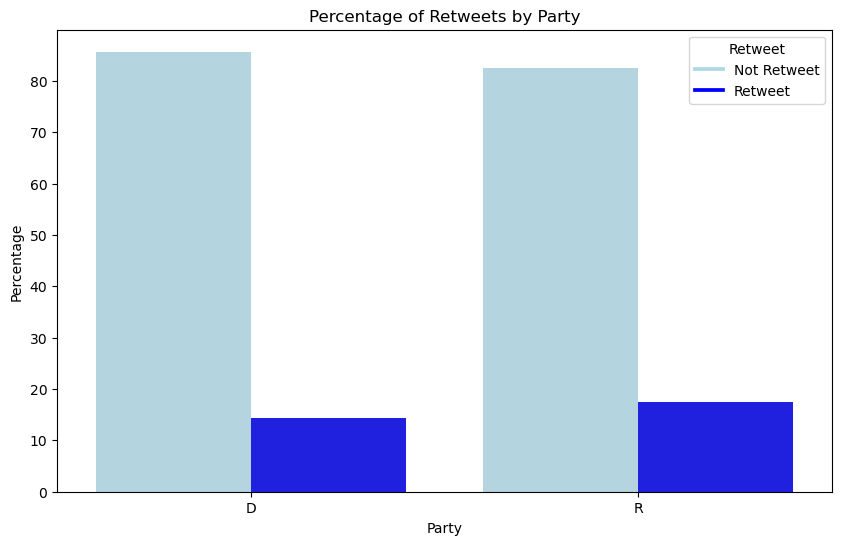

In [85]:
# Calculate the percentage of retweets for each party
retweet_percentage = df_cleaned.groupby('party')['is_retweet'].value_counts(normalize=True) * 100
retweet_percentage = retweet_percentage.rename('Percentage').reset_index()

# Set custom colors for the plot
colors = ['lightblue', 'blue']

# Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=retweet_percentage['party'], y=retweet_percentage['Percentage'], hue=retweet_percentage['is_retweet'], palette=colors)
plt.title('Percentage of Retweets by Party')
plt.xlabel('Party')
plt.ylabel('Percentage')

# Customize legend
legend_labels = ['Not Retweet', 'Retweet']
legend = plt.legend(title='Retweet', loc='upper right', labels=legend_labels)
legend.legendHandles[0].set_color(colors[0])
legend.legendHandles[1].set_color(colors[1])

### Binarize Party

- **Democrat = 1**
- **Republican = 0**

In [86]:
# Binarize the Party Column
df_cleaned['is_democrat'] = df_cleaned['party'].apply(lambda x: 1 if 'D' in x else 0)
print(df_cleaned.shape[0])
df_cleaned.head()

9528


,user_id,tweet,party,is_retweet,is_democrat
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R,0,0
1,76452765,I was sorry to hear of the passing of longtime...,R,0,0
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R,1,0
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R,0,0
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R,0,0


Now we will extract all of the hashtags in the database

### Extract hashtags for each tweet

We will create a new columns holding the hashtags, if any, for each tweet.

Additionally, we will create a list of all hashtags for democrats and republicans

In [87]:
# Create a new column with the hashtags for each tweet
df_cleaned['hashtags'] = None

#Iterate over each row in df['Tweets']
for index, row in df_cleaned.iterrows():
    # Use regex findall to search for all hashtags in each row
    hashtags = re.findall(r'#(\w+)', row['tweet'])
    if hashtags:
        # Add the hashtags, if any, in the columns 'Hashtags' for each row
        df_cleaned.at[index, 'hashtags'] = hashtags


In [88]:
# Check results
df_cleaned['hashtags']

0                                  None
1                                  None
2                                  None
3                                  None
4                                  None
                     ...               
9698                               None
9699    [LawEnforcementAppreciationDay]
9700                               None
9701                               None
9702                               None
Name: hashtags, Length: 9528, dtype: object

In [89]:
# Create two empty lists to store hashtags
republican_hashtags = []
democrat_hashtags = []

# Loop through each row to add hashtags to list
for index, row in df_cleaned.iterrows():
    if row['is_democrat'] == 1 and row['hashtags'] is not None:
        democrat_hashtags.extend(row['hashtags'])
    elif row['hashtags'] is not None:
        republican_hashtags.extend(row['hashtags'])

##### Visualize the top 10 hashtags for Democrats and Republicans

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'MLKDay'),
  Text(1, 0, 'NationalSchoolChoiceWeek'),
  Text(2, 0, 'FL02'),
  Text(3, 0, 'Bidenomics'),
  Text(4, 0, 'ProLife'),
  Text(5, 0, 'WhyWeMarch'),
  Text(6, 0, 'NationalMilkDay'),
  Text(7, 0, 'SchoolChoiceWeek'),
  Text(8, 0, 'MarchForLife'),
  Text(9, 0, 'IA04')])

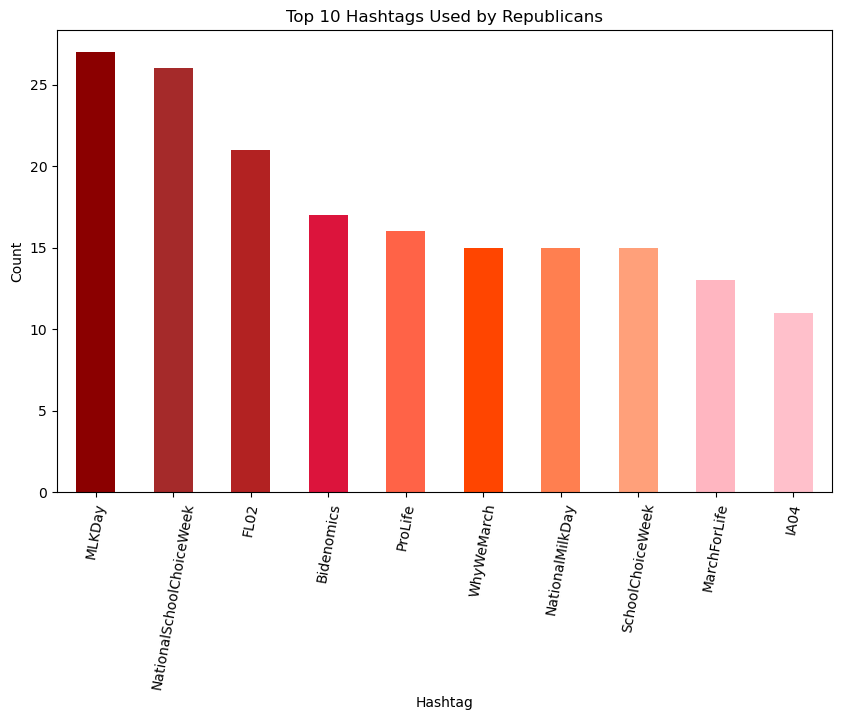

In [90]:
# Plot the 10 most used hasthags for Republicans

# Convert the list of Democrat hashtags to a Pandas Series and count occurrences
republican_10 = pd.Series(republican_hashtags).value_counts().head(10)
custom_red_colors = [
    '#8B0000',  # Dark red
    '#A52A2A',  # Brown
    '#B22222',  # Firebrick
    '#DC143C',  # Crimson
    '#FF6347',  # Tomato
    '#FF4500',  # Orange red
    '#FF7F50',  # Coral
    '#FFA07A',  # Light salmon
    '#FFB6C1',  # Light pink
    '#FFC0CB'   # Pink
]

# plot
republican_10.plot(kind='bar', figsize=(10,6), color=custom_red_colors)
plt.title('Top 10 Hashtags Used by Republicans')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 80)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'WIC'),
  Text(1, 0, 'FundWIC'),
  Text(2, 0, 'RoevWade'),
  Text(3, 0, 'MLKDay'),
  Text(4, 0, 'GVSurvivorsWeek'),
  Text(5, 0, 'RoeVWade'),
  Text(6, 0, 'ReproductiveFreedom'),
  Text(7, 0, 'IL03'),
  Text(8, 0, 'PeopleOverPolitics'),
  Text(9, 0, 'ACA')])

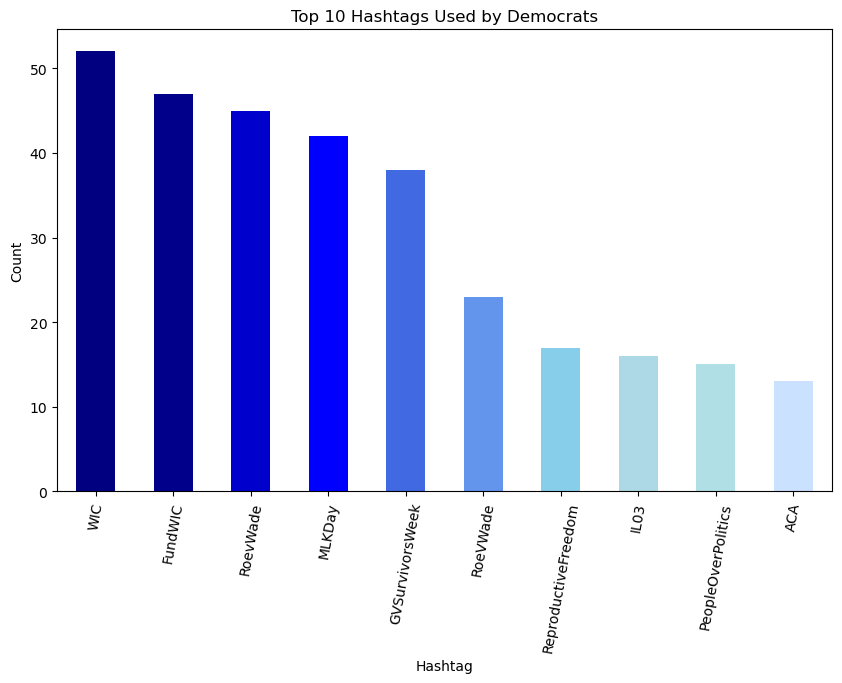

In [91]:
# Plot the 10 most used hasthags for Republicans

# Convert the list of Democrat hashtags to a Pandas Series and count occurrences
democrat_10 = pd.Series(democrat_hashtags).value_counts().head(10)
# Define custome colors to plot
custom_blue_colors = [
    '#000080',  # Navy
    '#00008B',  # Dark blue
    '#0000CD',  # Medium blue
    '#0000FF',  # Blue
    '#4169E1',  # Royal blue
    '#6495ED',  # Cornflower blue
    '#87CEEB',  # Sky blue
    '#ADD8E6',  # Light blue
    '#B0E0E6',  # Powder blue
    '#CAE1FF'   # Light steel blue
]
# Plot
democrat_10.plot(kind='bar', figsize=(10,6), color=custom_blue_colors)
plt.title('Top 10 Hashtags Used by Democrats')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.xticks(rotation = 80)

## Word Cloud for Democrat and Republican Hashtags

A word cloud is displayed showing the top hashtags from both republican and democrat hashtags. 

In [92]:
# Word Cloud
!pip install wordcloud
from wordcloud import WordCloud


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


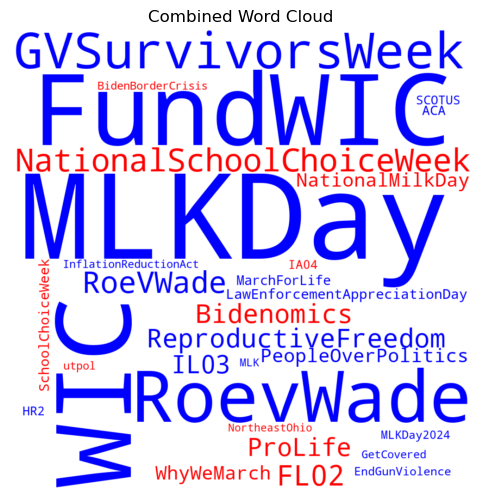

In [136]:
# Example data
democrat_text = " ".join(democrat_hashtags)
republican_text = " ".join(republican_hashtags)

# Function to get word frequencies
def get_word_frequencies(text):
    words = text.split()
    word_freq = {word: words.count(word) for word in set(words)}
    return word_freq

# Get word frequencies for Democrat and Republican hashtags
democrat_word_freq = get_word_frequencies(democrat_text)
republican_word_freq = get_word_frequencies(republican_text)

# Combine word frequencies
combined_word_freq = {word: democrat_word_freq.get(word, 0) + republican_word_freq.get(word, 0) for word in set(list(democrat_word_freq.keys()) + list(republican_word_freq.keys()))}

# Generate word cloud with custom coloring function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "blue" if word in democrat_word_freq else "red"

wordcloud = WordCloud(width=1000, height=1000,
                      background_color='white',
                      max_words=30,
                      color_func=color_func
                      ).generate_from_frequencies(combined_word_freq)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Combined Word Cloud')
plt.axis('off')
plt.show()


Upon examination, it becomes evident that the majority of frequent hashtags originate from Democrat tweets. This observation might suggest a tendency for Democrats to employ more embellishment when conveying a topic, contrasting with Republicans who appear to express themselves more independently. Additionally, certain hashtags, such as MLKDay, are prevalent in tweets from both parties but are categorized as blue since they appear more frequently in Democrat tweets than in Republican tweets.

In [94]:
# Before preprocessing, we want to make sure the distribution of Democratic and Republican is balanced again

# Count the occurrences of each party in the 'Party' column
parties_counts = df_cleaned['party'].value_counts()

# Calculate the total number of occurrences
normalized_counts = parties_counts.sum()

# Dictionary to store the percentage of tweets for each party
tweets_percentage = {}

# Calculate the percentage of tweets for each party and store in the dictionary
for party, count in parties_counts.items():
    tweets_percentage[party] = f"{count/normalized_counts*100:.2f}%"

# Display the dictionary containing the percentage of tweets for each party
tweets_percentage


{'D': '50.21%', 'R': '49.79%'}

The distribution is fair enough, it is almost 50/50, se we can continue processing the data

## Data Cleaning

In [95]:
# Import Necessary Libraries and Modules
import string

# SK Packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Vectorizers
from sklearn.feature_extraction.text import CountVectorizer

# NLTK
import nltk

# Downloads
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')

# Other nltk modules
from nltk.corpus import stopwords
import nltk as nlp
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Defining Stopwords

In [96]:
# define stopwords
stopwords = stopwords.words('english')

# add some unnecessary word to stopwords list
# some are abbreviation used by people to save caracters
stopwords.append("rt") # retweets
stopwords.append("u") # you
stopwords.append("r") # are
stopwords.append("amp") # ampersand
stopwords.append("w") # with
stopwords.append("th") #hat tip
stopwords.append("s")

# print the length of the stopwords
len(stopwords)

186

#### Cleaning Tweets

In [97]:
# # Create a lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a function to clean the tweets
def clean_tweets(tweet):

    # Remove @ sign and all handles
    tweet = re.sub("@[A-Za-z0-9]+", "", tweet)

    # Remove hashtags and words that come together with hashtags
    tweet = re.sub(r'#\w+', '', tweet)

    # Remove all punctuation. It also removes hashtags.
    tweet = re.sub("[!@$%^&*()_+\|/?,.:;'`’]+", "", tweet)

    # Remove links
    tweet = re.sub(r'http\S+', '', tweet)

    # lowercase all characters
    tweet = tweet.lower()

    # Remove extra whitespace
    tweet = " ".join(tweet.split())

    # Remove stopwords
    tweet = ' '.join([word for word in tweet.split() if word.lower() not in stopwords])

    # Lemmatization
    tokens = nltk.word_tokenize(tweet)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tweet = " ".join(lemmatized_tokens)

    # Remove three dots from the final word, preserving the word itself
    tweet = re.sub(r'(\S+)\.{2,}$', r'\1', tweet)

    # Remove dots from the end of the final word, even if there are fewer than three
    tweet = re.sub(r'\.+$', '', tweet)

    # Remove the last word '...'
    tweet = tweet.rsplit(' ', 1)[0]

    return tweet

# Create a new column with the cleaned text for every tweet
df_cleaned['clean_tweet'] = df_cleaned['tweet'].map(clean_tweets)

In [98]:
# Proof check results
print(df_cleaned['clean_tweet'][200])
print(df_cleaned['tweet'][200])

host press conference following passing hr 5779 hr 6957 hr
RT @housebudgetGOP: .@RepArrington Hosts Press Conference Following the Passing of H.R. 5779, H.R. 6957, and H.R. 6952. https://t.co/TlFqiA…


In [99]:
# Visualize new columns
df_cleaned.head()

,user_id,tweet,party,is_retweet,is_democrat,hashtags,clean_tweet
0,76452765,"On Joe Biden's first day in the Oval Office, h...",R,0,0,None,joe bidens first day oval office signed legisl...
1,76452765,I was sorry to hear of the passing of longtime...,R,0,0,None,sorry hear passing longtime caregiver leo lion...
2,76452765,RT @1819News: U.S. Rep. Robert Aderholt (R-Hal...,R,1,0,None,u rep robert aderholt r-haleyville recently to...
3,76452765,I’m sorry to hear of Anthony’s passing. He fre...,R,0,0,None,im sorry hear anthony passing frequently inter...
4,76452765,H.R. 6914 Pregnant Students’ Rights Act: Colle...,R,0,0,None,hr 6914 pregnant student right act college uni...


## Preprocesing

In [107]:
# CountVectorizer
vectorizer = CountVectorizer(
    max_df = 0.95,
    min_df = 10,
    ngram_range = (1,2) #search for unigrams and bigrams
)

Splitting the data into training and testing sets

In [108]:
# Tokenize the 'Tweet' column
# PD Conancat between the vectorizer text and the remaning columns

#run the fit transform first and then do the toarray() to get it back intoa numpy format and the pd concat it into the other column I want to do.

X = df_cleaned.drop(columns = ['tweet', 'party', 'user_id', 'is_democrat'])

# Define target variable
y = df_cleaned['is_democrat']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42, stratify=y)

In [109]:
X_train.shape[0]

6669

In [110]:
unique_words_list = set(" ".join(list(X_train["clean_tweet"])).split())

In [111]:
len(unique_words_list)

12750

##### Transforming the Cleaned Tweets Column

In [112]:
# fitting the CountVectorizer to the cleaned tweets
vectorizer.fit(X_train['clean_tweet'])

# Transforming the Positive_Review column in the training data into a dense array.
# This is necessary for compatibility with the subsequent DataFrame creation.
Tweet_X_train = vectorizer.transform(X_train['clean_tweet']).toarray()

# transforming the Positive_Review column in the testing data.
Tweet_X_test = vectorizer.transform(X_test['clean_tweet']).toarray()

# Transforming the training data into a DataFrame with feature names as columns, prefixed with "pos_".
Tweet_X_train = pd.DataFrame(Tweet_X_train,columns=vectorizer.get_feature_names_out(),index=X_train.index).add_prefix("tweet_")

# Transforming the testing data into a DataFrame with feature names as columns, prefixed with "pos_".
Tweet_X_test = pd.DataFrame(Tweet_X_test,columns=vectorizer.get_feature_names_out(),index=X_test.index).add_prefix("tweet_")

##### Trasforming the Hshtags Columns

In [113]:
# Replace None values with empty strings
X_train['hashtags'] = X_train['hashtags'].apply(lambda x: '' if x is None else x)
X_test['hashtags'] = X_test['hashtags'].apply(lambda x: '' if x is None else x)

# Convert lists to strings
X_train['hashtags'] = X_train['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
X_test['hashtags'] = X_test['hashtags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# fitting the CountVectorizer to the hashtags
# might have to separate the list of hashtags into words with spaces
vectorizer.fit(X_train['hashtags'])

# Transforming the 'Hashtags' column for training data
Hashtags_X_train = vectorizer.transform(X_train['hashtags']).toarray()

# Transforming the 'Hashtags' column for testing data
Hashtags_X_test = vectorizer.transform(X_test['hashtags']).toarray()

# Transforming the training data into a DataFrame with feature names as columns, prefixed with "Hashtags_"
Hashtags_X_train = pd.DataFrame(Hashtags_X_train, columns=vectorizer.get_feature_names_out(), index=X_train.index).add_prefix("hashtags_")

# Transforming the testing data into a DataFrame with feature names as columns, prefixed with "Hashtags_"
Hashtags_X_test = pd.DataFrame(Hashtags_X_test, columns=vectorizer.get_feature_names_out(), index=X_test.index).add_prefix("hashtags_")

# Visualize features for reference
vectorizer.get_feature_names_out()

array(['bidenomics', 'endgunviolence', 'fl02', 'fundwic',
       'gvsurvivorsweek', 'marchforlife', 'mlkday',
       'nationalschoolchoiceweek', 'peopleoverpolitics', 'prolife',
       'reproductivefreedom', 'roevwade', 'whywemarch', 'wic',
       'wic fundwic'], dtype=object)

In [114]:
# Combining the sparse matrix of positive reviews with the numerical data in the training set.
# This concatenation ensures that the transformed text features are included alongside the original numerical features.
X_train_final = pd.concat([Tweet_X_train, Hashtags_X_train, X_train.drop(['clean_tweet', 'hashtags'], axis=1)],axis=1)

# Combining the sparse matrix of negative reviews with the numerical data
X_test_final = pd.concat([Tweet_X_test, Hashtags_X_test, X_test.drop(['clean_tweet', 'hashtags'], axis=1)],axis=1)

In [115]:
# Revise symmetry in the shape of the train and test sets
# Shape of the train and test sets
print(f'The shape of the X_train_final set is: {X_train_final.shape}')
print(f'The shape of the X_test_final set is: {X_test_final.shape}')
print(f'The shape of the y_train set is: {y_train.shape}')
print(f'The shape of the y_test set is: {y_test.shape}')

The shape of the X_train_final set is: (6669, 2531)
The shape of the X_test_final set is: (2859, 2531)
The shape of the y_train set is: (6669,)
The shape of the y_test set is: (2859,)


## Modelling

We will train a logistic regression model on the dataset and assess its accuracy on both the training and testing sets. Subsequently, we will compare these results with those obtained from the RandomForestClassifier in the pipeline. The model exhibiting the highest accuracy will undergo a more detailed evaluation through the construction and analysis of a confusion matrix.

### Scale the Data
Scale the data before modelling

In [140]:
from sklearn.preprocessing import StandardScaler

# Instantiatie
scaler = StandardScaler()

# fit
scaler.fit(X_train_final)

# Transform
X_train_scaled = scaler.transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)


### Logistic Regression

In [141]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize Logistic Regression model
logistic_model = LogisticRegression(C=0.1, tol=0.1, n_jobs=-1, solver='sag')

# Fit the model on training data
logistic_model.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, n_jobs=-1, solver='sag', tol=0.1)

In [143]:
# Predictions on training and testing data
train_preds = logistic_model.predict(X_train_scaled)
test_preds = logistic_model.predict(X_test_scaled)

# Calculate accuracy on training and testing sets
train_accuracy = accuracy_score(y_train, train_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")

Training Accuracy: 88.15%
Testing Accuracy: 77.51%


### Interpreting Results and Model Use
Training Accuracy: 88.15%
Testing Accuracy: 77.51%

Our analysis uncovers a slight overfitting in the model, evident in the disparity between training and testing accuracies. To tackle this concern, we delve into KBest feature selection, aiming to pinpoint an optimal subset of features—such as words in tweets or hashtags—to refine our model's precision.

KBest operates on all 2531 X_Train coefficients in 100-unit increments. Initially detecting signs of overfitting, reflected in the Logistic Regression model's accuracy results, we introduce regularization with a C value of 0.001. Regularization in logistic regression alleviates overfitting by penalizing large coefficients, fostering a more generalized model. The choice of C=0.001 dictates the strength of this regularization, with smaller values intensifying its effect.

Upon applying regularization to KBest feature selection, we observe performance improvements as the number of selected coefficients increases. However, accuracy consistently hovers above 70%. In comparison, the scaled Logistic Regression model exhibits higher training and test accuracies, though with a slight overfitting.

When it comes to our Tweet Classification Model, **choosing the slightly overfitted version is more convenient**, especially when we look at a dataset with just 9703 tweets from the last week (From Jan 24th, 2024). Why? Well, this model is like a tweet expert—it's been trained on a variety of tweet styles and features, making it a good fit for the unpredictable world of tweets.

In the realm of Tweet Analysis, tweets cover a lot of ground, from serious topics to the latest memes. And because tweets are all about individual expression and can be pretty unpredictable, having a model that's been exposed to a wide range of content during training is a big plus. This adaptability isn't just handy for handling the tweets we've seen so far; it's also great for dealing with future tweets. Even if the training data looked a bit too detailed before (what we call overfitting), it turns out that this diverse training set is a perfect match for the ever-changing nature of tweets. So, in simpler terms, our model is like a flexible language expert, ready to understand and classify tweets with all sorts of content, making it a go-to tool for keeping up with the dynamic world of tweets.

In [144]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

ks = list(range(1,2532,100))

trainAcc = []
testAcc = []

for k in ks:
    #instantiate
    myKbest = SelectKBest(f_regression, k=k).fit(X_train_final,y_train)
    
    #create a subset of the X data based on the k variables selected
    X_train_sel = myKbest.transform(X_train_final)
    X_test_sel = myKbest.transform(X_test_final)
    
    ### Regularization in Logistic Regression

    # When training a Logistic Regression model, the introduction of regularization is a crucial technique to prevent overfitting.
    # Overfitting occurs when the model learns the training data too well, capturing noise and specificities that may not generalize to new, unseen data.
    # Regularization involves adding a penalty term to the logistic regression cost function, discouraging the model from assigning excessive importance to any single feature.
    # This penalty is controlled by a hyperparameter known as `C`.
    # The `C` value determines the strength of the regularization effect. A smaller `C` increases the regularization strength, imposing a higher penalty on large coefficients.
    # On the other hand, a larger `C` relaxes the regularization, allowing the model to fit the training data more closely.

    # Regularization implemented in the provided Logistic Regression model:
    
    #create a linear model and assess
    model = LogisticRegression(C=0.001, tol=0.1, n_jobs=-1, solver='sag')
       
    # Fit model
    model.fit(X_train_sel, y_train)
    
    # Score
    trainAcc.append(model.score(X_train_sel, y_train))
    testAcc.append(model.score(X_test_sel, y_test))    

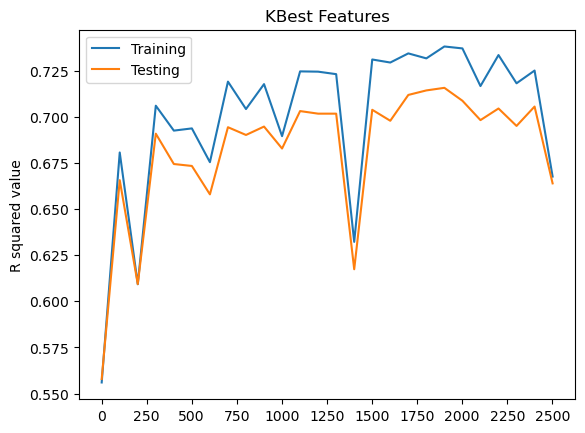

In [147]:
# Plot the KBest features
plt.figure()
plt.plot(ks, trainAcc, label='Training')
plt.plot(ks, testAcc, label = 'Testing')
plt.xticks(range(0,max(ks) + 1,250))
plt.ylabel('R squared value')
plt.title('KBest Features')
plt.legend()
plt.show()

While we've discussed the utility of favoring a slightly overfitted model for a Tweet Classification Model, the KBest results presented above indicate that there is no substantial difference beyond 1000 features. Therefore, if one opts to follow the KBest results, it would be prudent to run the model with only 1000 features to conserve computational resources. This approach not only helps in saving on features but also streamlines the iterations required for model training. Running the model with a reduced feature set enhances computational efficiency without significantly compromising performance, making it a practical choice for managing computational resources effectively.

1. TF-IDF VECTORIZER --> After running the pipeline --> it is showing that I have testes several values and params
1.1. do in the same process as I did to the count vectorizer
2. Words Embeddings in the Representation Learning Lecture
3. 

### Logistic Regression Pipeline

The provided Logistic Regression pipeline, which includes standardization using StandardScaler and a Logistic Regression model, along with GridSearchCV, is a comprehensive approach for optimizing the model's parameters. The pipeline systematically explores various configurations, including different scaling methods (StandardScaler and MinMaxScaler), regularization strengths (C values), and types (penalty), through cross-validated grid search. Additionally, the pipeline incorporates the flexibility to experiment with feature selection (SelectKBest) and dimensionality reduction (NMF) if needed. The GridSearchCV evaluates the model using the F1 macro score, facilitating the identification of the most effective combination of preprocessing steps and hyperparameters.

In [133]:
### from sklearn.decomposition import NMF
# from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

estimators = [('scale', StandardScaler()),
              # ('feature_selection', SelectKBest(f_classif)),  # Add SelectKBest before NMF
              # ('dim_red', NMF()),
              ('model', LogisticRegression(solver='sag'))]

pipe = Pipeline(estimators)

param_grid = [{'scale': [StandardScaler(), MinMaxScaler()],
               # 'feature_selection__k': [20, 50, 100],  # Adjust k for feature selection
               # 'dim_red__n_components': [5, 10, 20, 50, 100],  # Explore smaller component numbers
               'model__C':[0.001, 0.01, 0.1, 1, 10, 100],  # Reduce C values for less memory
               'model__penalty': ["l1","l2"],}]

grid = GridSearchCV(pipe,
                    param_grid,
                    cv=5,
                    verbose=2,
                    n_jobs=1,  # Set to 1 for conservative memory usage
                    scoring="f1_macro",
                    )

fittedgrid = grid.fit(X_train_final, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__C=0.001, model__penalty=l1, scale=StandardScaler(); total time=   2.5s
[CV] END model__C=0.001, model__penalty=l1, scale=StandardScaler(); total time=   2.0s
[CV] END model__C=0.001, model__penalty=l1, scale=StandardScaler(); total time=   2.7s
[CV] END model__C=0.001, model__penalty=l1, scale=StandardScaler(); total time=   1.9s
[CV] END model__C=0.001, model__penalty=l1, scale=StandardScaler(); total time=   1.9s
[CV] END model__C=0.001, model__penalty=l1, scale=MinMaxScaler(); total time=   1.4s
[CV] END model__C=0.001, model__penalty=l1, scale=MinMaxScaler(); total time=   1.5s
[CV] END model__C=0.001, model__penalty=l1, scale=MinMaxScaler(); total time=   1.4s
[CV] END model__C=0.001, model__penalty=l1, scale=MinMaxScaler(); total time=   1.4s
[CV] END model__C=0.001, model__penalty=l1, scale=MinMaxScaler(); total time=   1.3s
[CV] END model__C=0.001, model__penalty=l2, scale=StandardScaler(); total time

C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, scale=StandardScaler(); total time= 1.1min


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, scale=StandardScaler(); total time= 1.1min


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, scale=StandardScaler(); total time=  49.4s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, scale=StandardScaler(); total time=  37.8s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, scale=StandardScaler(); total time=  39.0s
[CV] END model__C=0.01, model__penalty=l2, scale=MinMaxScaler(); total time=  18.1s
[CV] END model__C=0.01, model__penalty=l2, scale=MinMaxScaler(); total time=  10.5s
[CV] END model__C=0.01, model__penalty=l2, scale=MinMaxScaler(); total time=  10.1s
[CV] END model__C=0.01, model__penalty=l2, scale=MinMaxScaler(); total time=  11.1s
[CV] END model__C=0.01, model__penalty=l2, scale=MinMaxScaler(); total time=  10.5s
[CV] END model__C=0.1, model__penalty=l1, scale=StandardScaler(); total time=   2.2s
[CV] END model__C=0.1, model__penalty=l1, scale=StandardScaler(); total time=   2.2s
[CV] END model__C=0.1, model__penalty=l1, scale=StandardScaler(); total time=   1.9s
[CV] END model__C=0.1, model__penalty=l1, scale=StandardScaler(); total time=   1.9s
[CV] END model__C=0.1, model__penalty=l1, scale=StandardScaler(); total time=   1.7s
[CV] END model__C=0.1, model__penalty=l1, scale=MinMaxScaler(); total

C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__penalty=l2, scale=StandardScaler(); total time= 1.1min


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__penalty=l2, scale=StandardScaler(); total time=  52.2s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__penalty=l2, scale=StandardScaler(); total time=  47.3s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__penalty=l2, scale=StandardScaler(); total time=  46.8s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=0.1, model__penalty=l2, scale=StandardScaler(); total time=  34.7s
[CV] END model__C=0.1, model__penalty=l2, scale=MinMaxScaler(); total time=   4.4s
[CV] END model__C=0.1, model__penalty=l2, scale=MinMaxScaler(); total time=   4.7s
[CV] END model__C=0.1, model__penalty=l2, scale=MinMaxScaler(); total time=   5.3s
[CV] END model__C=0.1, model__penalty=l2, scale=MinMaxScaler(); total time=   4.4s
[CV] END model__C=0.1, model__penalty=l2, scale=MinMaxScaler(); total time=   4.8s
[CV] END model__C=1, model__penalty=l1, scale=StandardScaler(); total time=   0.8s
[CV] END model__C=1, model__penalty=l1, scale=StandardScaler(); total time=   0.7s
[CV] END model__C=1, model__penalty=l1, scale=StandardScaler(); total time=   0.7s
[CV] END model__C=1, model__penalty=l1, scale=StandardScaler(); total time=   0.7s
[CV] END model__C=1, model__penalty=l1, scale=StandardScaler(); total time=   0.8s
[CV] END model__C=1, model__penalty=l1, scale=MinMaxScaler(); total time=   0.5s
[CV]

C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1, model__penalty=l2, scale=StandardScaler(); total time=  19.3s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1, model__penalty=l2, scale=StandardScaler(); total time=  16.0s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1, model__penalty=l2, scale=StandardScaler(); total time=  17.3s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1, model__penalty=l2, scale=StandardScaler(); total time=  16.4s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=1, model__penalty=l2, scale=StandardScaler(); total time=  20.8s
[CV] END model__C=1, model__penalty=l2, scale=MinMaxScaler(); total time=   6.3s
[CV] END model__C=1, model__penalty=l2, scale=MinMaxScaler(); total time=  10.2s
[CV] END model__C=1, model__penalty=l2, scale=MinMaxScaler(); total time=   7.0s
[CV] END model__C=1, model__penalty=l2, scale=MinMaxScaler(); total time=   7.5s
[CV] END model__C=1, model__penalty=l2, scale=MinMaxScaler(); total time=  10.0s
[CV] END model__C=10, model__penalty=l1, scale=StandardScaler(); total time=   0.6s
[CV] END model__C=10, model__penalty=l1, scale=StandardScaler(); total time=   0.6s
[CV] END model__C=10, model__penalty=l1, scale=StandardScaler(); total time=   0.6s
[CV] END model__C=10, model__penalty=l1, scale=StandardScaler(); total time=   0.6s
[CV] END model__C=10, model__penalty=l1, scale=StandardScaler(); total time=   0.7s
[CV] END model__C=10, model__penalty=l1, scale=MinMaxScaler(); total time=   0.4s
[CV] END m

C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=StandardScaler(); total time=  16.8s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=StandardScaler(); total time=  16.2s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=StandardScaler(); total time=  16.7s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=StandardScaler(); total time=  16.6s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=StandardScaler(); total time=  16.2s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=MinMaxScaler(); total time=  15.7s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=MinMaxScaler(); total time=  16.4s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=MinMaxScaler(); total time=  16.2s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=MinMaxScaler(); total time=  16.2s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, scale=MinMaxScaler(); total time=  16.0s
[CV] END model__C=100, model__penalty=l1, scale=StandardScaler(); total time=   0.6s
[CV] END model__C=100, model__penalty=l1, scale=StandardScaler(); total time=   0.6s
[CV] END model__C=100, model__penalty=l1, scale=StandardScaler(); total time=   0.5s
[CV] END model__C=100, model__penalty=l1, scale=StandardScaler(); total time=   0.7s
[CV] END model__C=100, model__penalty=l1, scale=StandardScaler(); total time=   0.7s
[CV] END model__C=100, model__penalty=l1, scale=MinMaxScaler(); total time=   0.4s
[CV] END model__C=100, model__penalty=l1, scale=MinMaxScaler(); total time=   0.5s
[CV] END model__C=100, model__penalty=l1, scale=MinMaxScaler(); total time=   0.5s
[CV] END model__C=100, model__penalty=l1, scale=MinMaxScaler(); total time=   0.5s
[CV] END model__C=100, model__penalty=l1, scale=MinMaxScaler(); total time=   0.5s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=StandardScaler(); total time=  16.4s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=StandardScaler(); total time=  16.3s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=StandardScaler(); total time=  16.0s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=StandardScaler(); total time=  16.7s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=StandardScaler(); total time=  16.5s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=MinMaxScaler(); total time=  15.8s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=MinMaxScaler(); total time=  20.0s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=MinMaxScaler(); total time=  16.5s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END model__C=100, model__penalty=l2, scale=MinMaxScaler(); total time=  16.6s


C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\erick\aanaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *ar

[CV] END model__C=100, model__penalty=l2, scale=MinMaxScaler(); total time=  15.9s


In [138]:
# # Print the best parameters and corresponding accuracy
print("Best Parameters:", grid.best_params_)
print(f"Best Accuracy: {grid.best_score_*100:.2f}%")

Best Parameters: {'model__C': 0.001, 'model__penalty': 'l2', 'scale': StandardScaler()}
Best Accuracy: 76.52%


### Analyzing Results

In this specific case, the optimal configuration includes a Logistic Regression model with a regularization parameter (C) set to 0.001, using 'l2' penalty, and employing StandardScaler for feature scaling. The achieved accuracy with these parameters is 76.52%.

Comparing to the initial Logistic Regression results, with a training accuracy of 88.15% and a testing accuracy of 77.51%, the grid search results demonstrate a slightly lower accuracy. This could be attributed to the regularization applied during the grid search, which aims to prevent overfitting by penalizing large coefficients. The chosen regularization parameters may have resulted in a more generalized model, trading off a bit of training accuracy for improved generalization to unseen data. The grid search process ensures that the model is tuned to perform well across various parameter configurations, contributing to its robustness in handling diverse scenarios.

### TF-IDF Vectorizor

The TF-IDF is made of two measures, term frequency (TF) and inverse document frequency (IDF). 

For a term (a word or phrase), $t$, and a document ,$d$, the term frequency $\text{TF}(t,d)$, measures how common the term is in the document. 

The inverse document frequency of a term $t$, $\text{IDF}(t)$, is the inverse of the number of documents a term $t$ appears in.

The intuition is that when a term appears in many documents, it's not very relevant. However, if it only appears in a few documents, it's very relevant to identifying those documents.

In [172]:
# Import library
from sklearn.feature_extraction.text import TfidfVectorizer

# Instatiate
tfidf_vectorizer = TfidfVectorizer(
    # max_df = 0.95,
    # min_df = 10,
    # ngram_range = (1,2) #search for unigrams and bigrams
)

# Fit
tfidf = tfidf_vectorizer.fit(df_cleaned['clean_tweet'])

# Transform
clean_tweet_transformed = tfidf.transform((df_cleaned['clean_tweet']))

In [173]:
clean_tweet_transformed.shape

(9528, 13874)

In [175]:
my_df =  pd.DataFrame(columns=tfidf.get_feature_names_out(), data=clean_tweet_transformed.toarray())
display(my_df)

,00,0040,01,0137,0213,02s,03,04,05,0548,...,𝒘𝒊𝒕𝒉,𝗖𝗟𝗢𝗦𝗘𝗗,𝗽𝗲𝗿𝗺𝗮𝗻𝗲𝗻𝘁𝗹𝘆,𝟐𝟎𝟐𝟒,𝟐𝟕𝟏,𝟑𝟐𝟖,𝟑𝟑𝟕,𝟓𝟕𝟕𝟗,𝟔𝟗𝟓𝟐,𝟔𝟗𝟓𝟕
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [182]:
# using our custom tokenizer in TfidfVectorizer

tfidf = TfidfVectorizer(
                        # words must appear at least 5 times
                        min_df=5,
                        #ngrams included
                        ngram_range=(1,2))
tfidf.fit(X_train_final)

X_train_transformed = tfidf.transform(X_train_final)
X_test_transformed = tfidf.transform(X_test_final)

X_train_transformed.shape

(2531, 52)

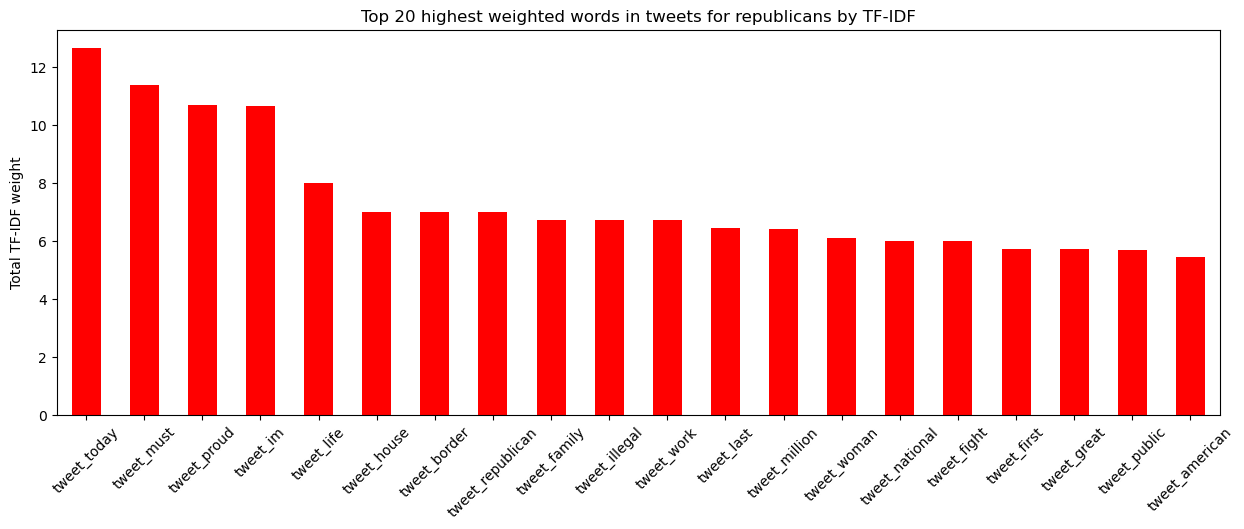

In [187]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.loc[word_counts.index.str.startswith('tweet_'),:].head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')
plt.title("Top 20 highest weighted words in tweets for republicans by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

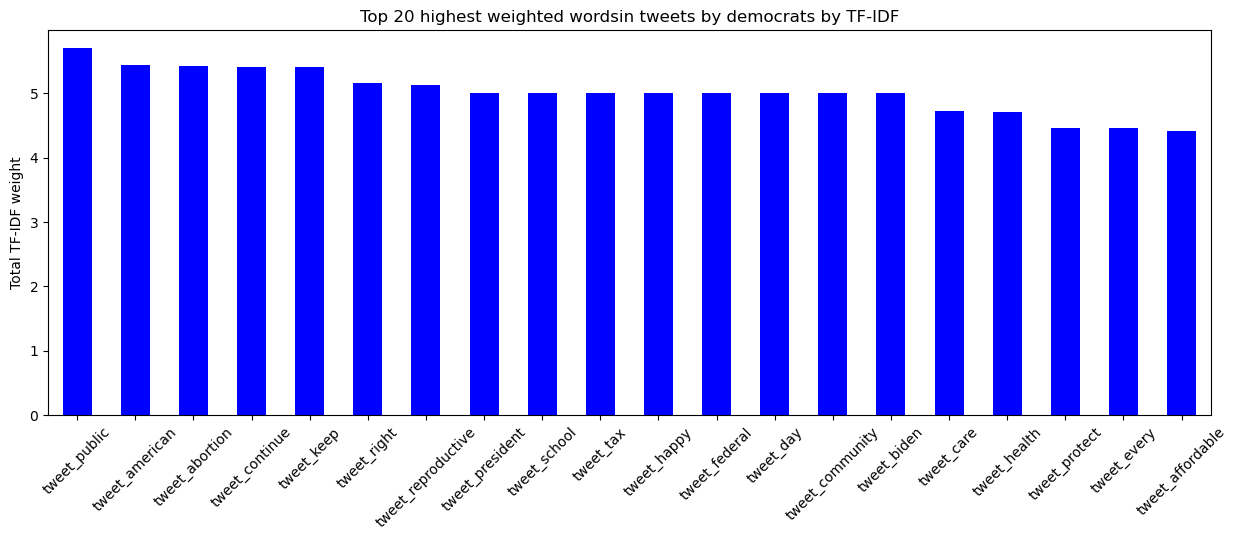

In [188]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts.loc[word_counts.index.str.startswith('tweet_'),:].tail(20).plot(kind="bar", figsize=(15, 5), legend=False, color='blue')
plt.title("Top 20 highest weighted wordsin tweets by democrats by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

In [191]:
# word_counts = pd.DataFrame(
#     {"counts": X_train_transformed.toarray().sum(axis=0)},
#     index=tfidf.get_feature_names_out()
# ).sort_values("counts", ascending=False)

# word_counts.loc[word_counts.index.str.startswith('hashtags_'),:].head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')
# plt.title("Top 20 highest weighted hashtags for republicans by TF-IDF")
# plt.ylabel("Total TF-IDF weight")
# plt.xticks(rotation=45)
# plt.show()

In [192]:
# word_counts = pd.DataFrame(
#     {"counts": X_train_transformed.toarray().sum(axis=0)},
#     index=tfidf.get_feature_names_out()
# ).sort_values("counts", ascending=False)

# word_counts.loc[word_counts.index.str.startswith('hashtags_'),:].tail(20).plot(kind="bar", figsize=(15, 5), legend=False, color='blue')
# plt.title("Top 20 highest weighted hashtags for democrats by TF-IDF")
# plt.ylabel("Total TF-IDF weight")
# plt.xticks(rotation=45)
# plt.show()

### Word Embedding

### Top Words and Hashtags for Republican and Democrat Tweets

By analyzing the highest model coefficients, we gain valuable insights into the words that significantly contribute to the model's ability to predict democrat or republican tweets. The bar plots offer a clear visualization of the importance of each word in influencing sentiment predictions.

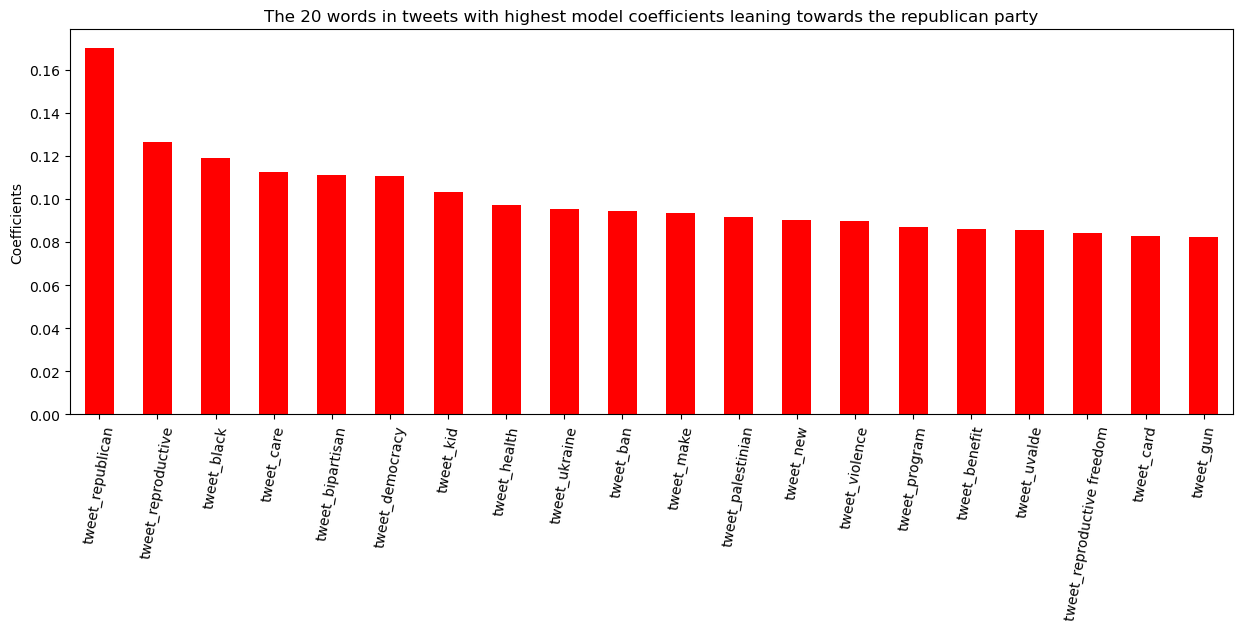

In [151]:
# Extracting the top 20 words from tweets to predict if a tweet has republican inclinations.
word_counts = pd.DataFrame(
    {"coefficients": logistic_model.coef_[0]},
    index=X_train_final.columns
).sort_values("coefficients", ascending=False)

# Plot the top 20 words for republican tweets
word_counts.loc[word_counts.index.str.startswith('tweet_'),:].head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')
plt.title("The 20 words in tweets with highest model coefficients leaning towards the republican party")
plt.ylabel("Coefficients")
plt.xticks(rotation=80)
plt.show()

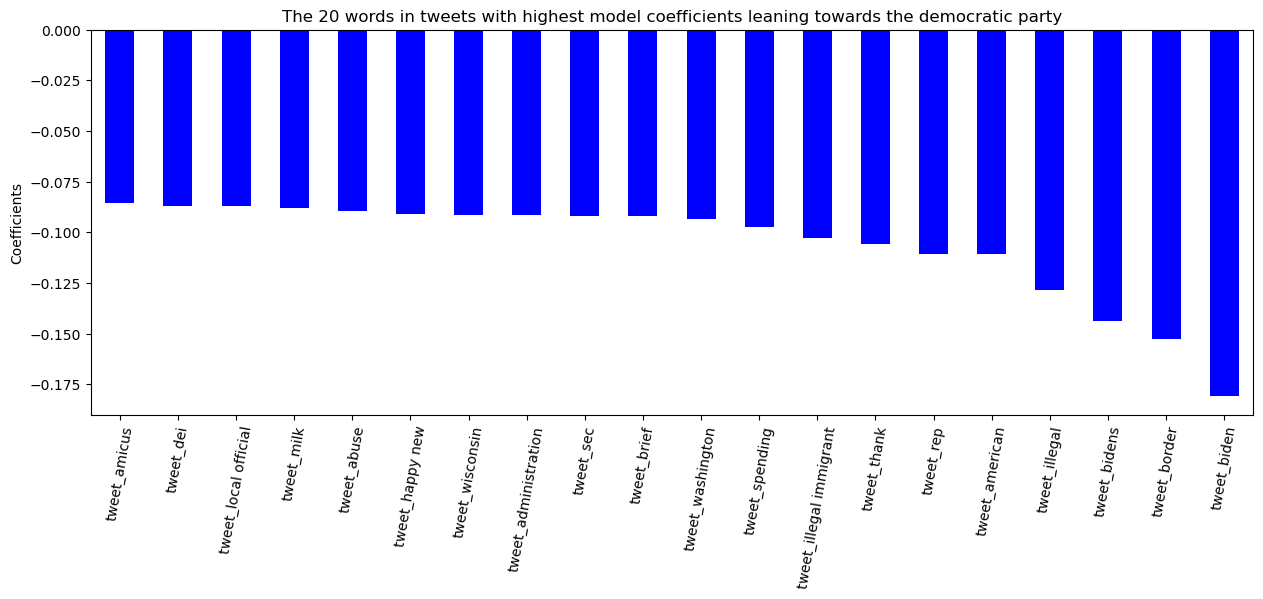

In [152]:
# Extracting the top 20 words to predict democrat tweets
word_counts = pd.DataFrame(
    {"coefficients": logistic_model.coef_[0]},
    index=X_train_final.columns
).sort_values("coefficients", ascending=False)

# Plot the top 20 words for democrat tweets
word_counts.loc[word_counts.index.str.startswith('tweet_'),:].tail(20).plot(kind="bar", figsize=(15, 5), legend=False, color='blue')
plt.title("The 20 words in tweets with highest model coefficients leaning towards the democratic party")
plt.ylabel("Coefficients")
plt.xticks(rotation=80)
plt.show()

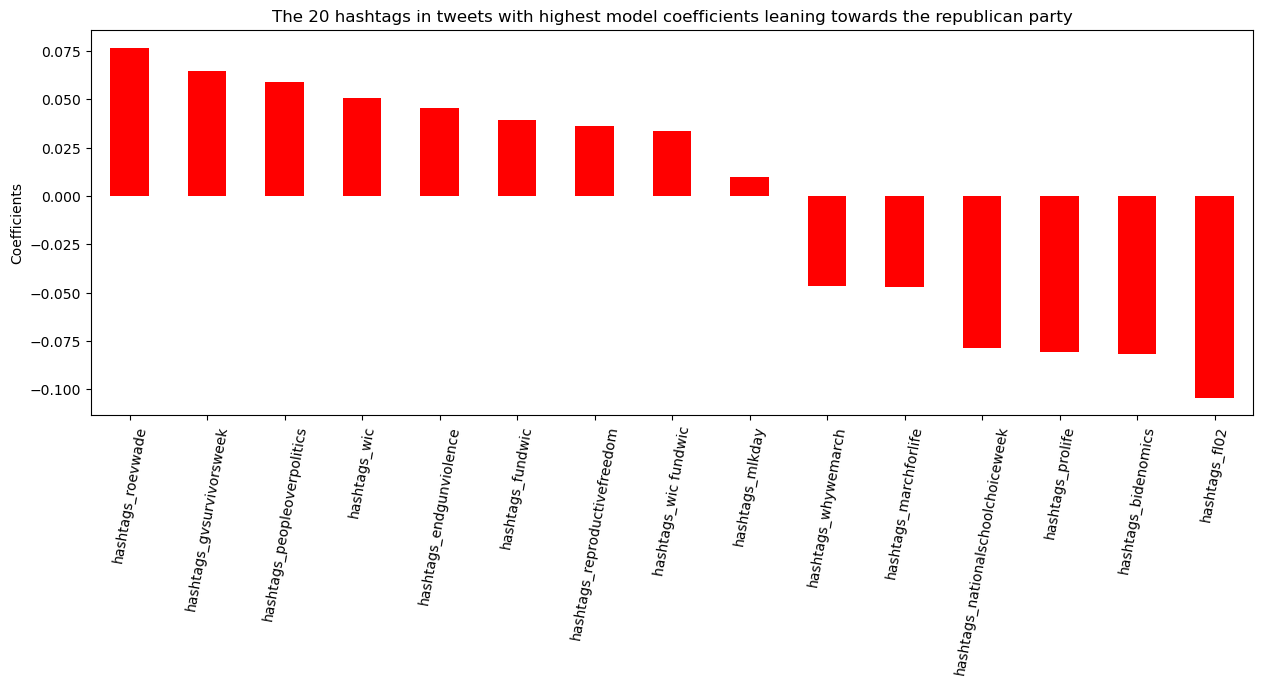

In [156]:
# Extracting the top 20 hashtags to predict republican tweets
word_counts = pd.DataFrame(
    {"coefficients": logistic_model.coef_[0]},
    index=X_train_final.columns
).sort_values("coefficients", ascending=False)


# Plot the top 20 hashtags for republican tweets
word_counts.loc[word_counts.index.str.startswith('hashtags_'),:].head(20).plot(kind="bar", figsize=(15, 5), legend=False, color='red')
plt.title("The 20 hashtags in tweets with highest model coefficients leaning towards the republican party")
plt.ylabel("Coefficients")
plt.xticks(rotation=80)
plt.show()

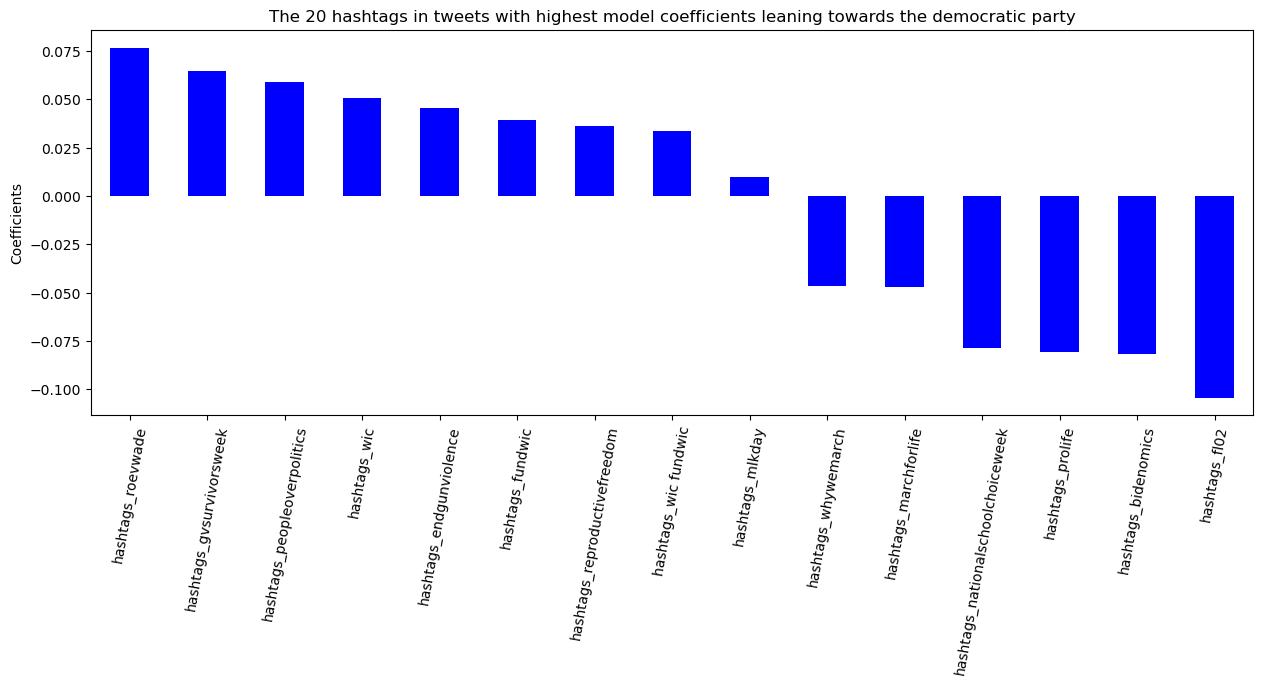

In [157]:
# Extracting the top 20 hashtags to predict democrat tweets
word_counts = pd.DataFrame(
    {"coefficients": logistic_model.coef_[0]},
    index=X_train_final.columns
).sort_values("coefficients", ascending=False)


# Plot the top 20 hashtags for democrat tweets
word_counts.loc[word_counts.index.str.startswith('hashtags_'),:].tail(20).plot(kind="bar", figsize=(15, 5), legend=False, color='blue')
plt.title("The 20 hashtags in tweets with highest model coefficients leaning towards the democratic party")
plt.ylabel("Coefficients")
plt.xticks(rotation=80)
plt.show()

### Building a Pipeline for a Random Forest Classifier

Employing a pipeline, the data will undergo scaling and, in conjunction with Principal Component Analysis (PCA), a decision tree classifier will be constructed.

In [197]:
# from sklearn.decomposition import NMF
# from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Define the pipeline with RandomForestClassifier
estimators_rf = [('scale', StandardScaler()),
                 # ('dim_red', NMF()),
                 # ('feature_selection', SelectKBest(f_classif)),
                 ('model', RandomForestClassifier())]

pipe_rf = Pipeline(estimators_rf)


param_grid_rf = [{'scale': [StandardScaler(), MinMaxScaler()]
               # 'feature_selection__k': [20, 50, 100],  # Adjust k for feature selection
               # 'dim_red__n_components': [5, 10, 20, 50, 100],  # Explore smaller component numbers
               # # 'model__C':[0.001, 0.01, 0.1, 1, 10, 100],  # Reduce C values for less memory
               # 'model__penalty': ["l1","l2"],
                 }]

grid_rf = GridSearchCV(pipe_rf,
                    param_grid_rf,
                    cv=5,
                    verbose=2,
                    n_jobs=1,  # Set to 1 for conservative memory usage
                    scoring="f1_macro",
                    )

fittedgrid_rf = grid_rf.fit(X_train_final, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .............................scale=StandardScaler(); total time=  23.9s
[CV] END .............................scale=StandardScaler(); total time=  19.8s
[CV] END .............................scale=StandardScaler(); total time=  20.4s
[CV] END .............................scale=StandardScaler(); total time=  20.4s
[CV] END .............................scale=StandardScaler(); total time=  20.4s
[CV] END ...............................scale=MinMaxScaler(); total time=  20.5s
[CV] END ...............................scale=MinMaxScaler(); total time=  19.4s
[CV] END ...............................scale=MinMaxScaler(); total time=  19.9s
[CV] END ...............................scale=MinMaxScaler(); total time=  19.3s
[CV] END ...............................scale=MinMaxScaler(); total time=  19.3s


In [198]:
# # Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_rf.best_params_)
print(f"Best Accuracy: {grid_rf.best_score_*100:.2f}%")

Best Parameters: {'scale': StandardScaler()}
Best Accuracy: 76.08%


### Building a Pipeline for a SVM

In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification


# Create a pipeline with StandardScaler, PCA, and SVM
estimators_svc = [('scale', StandardScaler()),
                  ('model', svm.SVC())]

pipe_svc = Pipeline(estimators_svc)

# Define the parameter grid for GridSearchCV
param_grid_svc = [ {'model': [svm.SVC()],
                    'scale': [StandardScaler(), MinMaxScaler()],
                    'model__gamma': [0.1, 1, 10, 100],
                    'model__C': [ 0.1, 1, 10, 100]}
                 ]

# Create GridSearchCV object
grid_svc = GridSearchCV(pipe_svc,
                    param_grid_svc,
                    cv=5,
                    verbose=2,
                    n_jobs=1,  # Set to 1 for conservative memory usage
                    scoring="f1_macro"
                    )

# Fit the model
grid_svc.fit(X_train_final, y_train)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
# Print the best parameters and corresponding accuracy
print("Best Parameters:", grid_svc.best_params_)
print(f"Best Accuracy: {grid_svc.best_score_*100:.2f}%")

### RandomForest vs Log Reg
Results as compared to the Log Reg:

### Confusion Matrix

Examining the confusion matrix for the Logistic Regression model, which yielded a superior accuracy score.

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the following prediction already calculated above: test_preds = logistic_model.predict(X_test_scaled)

# Generate confusion matrix
reviews_matrix = confusion_matrix(y_test, test_preds)

# Label rows and columns
reviews_df = pd.DataFrame(
    reviews_matrix,
    columns=["Predicted Democrat", "Predicted Republican"],
    index=["True Democrat", "True Republican"]
)

display(reviews_df)

,Predicted Democrat,Predicted Republican
True Democrat,9909,3122
True Republican,3730,8604


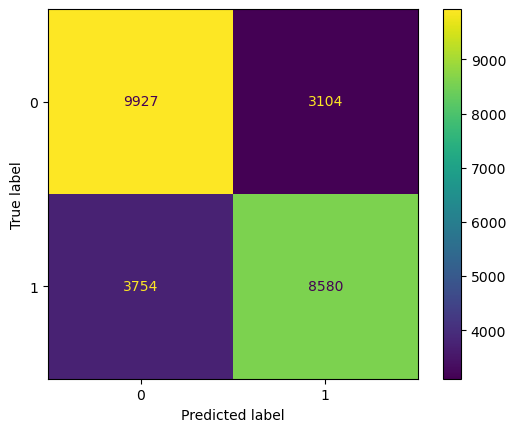

In [58]:
# the function expects the estimator, inputs and target as parameters
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test_scaled, y_test);

In [59]:
# select the FP from the confusion matrix
# true label 0 & predicted label 1
fp = reviews_matrix[0, 1]

print(f"{fp} democrats were misclassified as republicans.")

3122 democrats were misclassified as republicans.


In [61]:
# select the TP from the confusion matrix
# true label 1 & predicted label 1
tp = reviews_matrix[1, 1]

# total number of true label 1
bad_reviews = reviews_matrix[1, :].sum()

print(f"{tp} republicans were predicted correctly by the model out of {bad_reviews} republicans.")

8604 republicans were predicted correctly by the model out of 12334 republicans.


### Precission and Recall

In [62]:
# Precision 
from sklearn.metrics import precision_score

print(f"The precission score is: {precision_score(y_test, test_preds) * 100:.2f}%")

The precission score is: 73.38%


In [63]:
# Recall
from sklearn.metrics import recall_score

# recall_score(true labels, predicted labels)
print(f"The recall score is: {recall_score(y_test, test_preds) *100:.2f}%")

The recall score is: 69.76%


In [64]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, test_preds)
print(report_initial)

              precision    recall  f1-score   support

           0       0.73      0.76      0.74     13031
           1       0.73      0.70      0.72     12334

    accuracy                           0.73     25365
   macro avg       0.73      0.73      0.73     25365
weighted avg       0.73      0.73      0.73     25365



### Sentiment Analysis

## Conclusion

In concluding this phase of our project, our Logistic Regression model yielded notable insights into the classification of political tweets. The model exhibited a training accuracy of 78.44% and a testing accuracy of 72.99%. While these results provide a foundation, there is a recognition of the need for further refinement and validation.

Our analysis extends beyond accuracy metrics; the identification of top words and hashtags with the highest model coefficients unveils key features driving the model's predictions. This valuable information not only enhances our understanding of the current dataset but also lays the groundwork for predicting future tweets' political affiliations. The ability to discern the significance of specific words and hashtags in classifying tweets as Democrat or Republican is a powerful tool for interpreting and predicting online political discourse.

## Next Steps

Moving forward, our agenda encompasses several critical steps to refine and expand our analysis:

1. Cross-Validation for Logistic Regression: A crucial step to address the observed overfitting and further validate the model's performance.

2. Pipeline Implementation for Naive Bayes: We plan to extend our analysis by applying a Naive Bayes model through a pipeline, exploring its potential in classifying political tweets.

3. Memory Allocation Optimization: Resolving memory allocation issues is a priority, ensuring our models run seamlessly and efficiently on diverse platforms.

4. Sentiment Analysis Implementation: Introducing sentiment analysis specific to Democrat and Republican tweets will provide nuanced insights into the emotional tone of political discussions.

5. Identification of Top Words for Each Sentiment: Extending our analysis to discern the most significant words influencing sentiment in both Democrat and Republican tweets.

6. Scraping Additional Dataset: Augmenting our dataset through scraping will enhance the diversity and richness of our data, contributing to a more comprehensive understanding of political discourse.

7. Neural Network Application: Exploring the application of neural networks to gain deeper insights and potentially improve the predictive capabilities of our models.

8. Further Exploratory Data Analysis (EDA): Continuous exploration of the dataset will uncover additional patterns, trends, and relationships, enhancing the depth of our understanding.

As we embark on these next steps, the project's evolution promises to bring a more robust and detailed understanding of political tweets, contributing to the broader discourse surrounding digital political communication.
